In [1]:
from mp_api.client import MPRester
API_KEY = "4IeHY5jVcrgiKXNuAo6Jgs7yC0Z3hsli"
try:


    with MPRester(API_KEY) as mpr:
        # Query for Li-based cathode materials with high energy density
        docs = mpr.materials.insertion_electrodes.search(
            working_ion="Li",
            fields=[
                "battery_id", "formula_discharge", "average_voltage"
                , "energy_grav", "energy_vol", "capacity_grav", "capacity_vol", "stability_charge", "fracA_charge", "stability_charge", "max_delta_volume", "stability_discharge", "fracA_discharge"
            ]
        )

        # Convert to pandas for research analysis
        import pandas as pd
        df = pd.DataFrame([doc.dict() for doc in docs])
        print(df)

except Exception as e:
    print(f"An error occurred: {e}")


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Retrieving InsertionElectrodeDoc documents: 100%|██████████| 2774/2774 [00:00<00:00, 7239.50it/s] 


         battery_id  formula_discharge  max_delta_volume  average_voltage  \
0         mp-124_Li              Li3Ag          2.736089         0.210565   
1        mp-2074_Li              Li3Sb          1.569237         1.015953   
2       mp-22902_Li               LiBi          0.368255         0.796796   
3          mp-28_Li              Li3Ce          2.951183        -0.444846   
4          mp-45_Li              Li3Ca          1.513956        -0.064931   
...             ...                ...               ...              ...   
2769   mp-801332_Li     Li3VCrP2(HO5)2          0.076598        -0.048828   
2770   mp-802114_Li      LiMnVP2(HO5)2          0.045934        -2.235023   
2771   mp-806951_Li      LiVFeP2(O4F)2          0.017783         0.617592   
2772   mp-850538_Li  Li4Mn2Fe3Sn(PO4)6          0.058139         2.872942   
2773  mp-1227445_Li    BaSrLiNdTlCu2O7          0.071513         0.911354   

      capacity_grav  capacity_vol  energy_grav   energy_vol  fracA_charge  

In [10]:
from sklearn.cluster import KMeans
features = df[[
    "average_voltage",
    "capacity_grav",
    "max_delta_volume",
    "fracA_charge"
]].dropna()

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(features)

from sklearn.decomposition import PCA
import pandas as pd

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

loadings = pd.DataFrame(
    pca.components_.T,
    columns=["PC1", "PC2"],
    index=features.columns
)

print(loadings)


kmeans = KMeans(n_clusters=4, random_state=0)
labels = kmeans.fit_predict(X)

df["cluster"] = labels

df.groupby("cluster")[[
    "average_voltage",
    "capacity_grav",
    "max_delta_volume",
    "fracA_charge"
]].mean()

                       PC1       PC2
average_voltage  -0.514816 -0.525146
capacity_grav     0.487856 -0.414133
max_delta_volume  0.701630 -0.167958
fracA_charge      0.068387  0.724227


,average_voltage,capacity_grav,max_delta_volume,fracA_charge
cluster,,,,
0,2.195776,75.674094,0.043588,0.010419
1,4.104563,163.245008,0.072992,0.012018
2,3.185181,126.348879,0.031760,0.194990
3,-1.859257,178.401335,13.517787,0.000000


In [2]:
import pandas as pd

df = pd.DataFrame([doc.dict() for doc in docs])

df.head()


,battery_id,formula_discharge,max_delta_volume,average_voltage,capacity_grav,capacity_vol,energy_grav,energy_vol,fracA_charge,fracA_discharge,stability_charge,stability_discharge,fields_not_requested
0,mp-124_Li,Li3Ag,2.736089,0.210565,624.785871,1984.816229,131.558310,417.933696,0.0,0.75,0.003609,0.000000,"[builder_meta, battery_type, thermo_type, batt..."
1,mp-2074_Li,Li3Sb,1.569237,1.015953,563.913254,1890.293779,572.909146,1920.448911,0.0,0.75,0.328351,0.000000,"[builder_meta, battery_type, thermo_type, batt..."
2,mp-22902_Li,LiBi,0.368255,0.796796,124.126099,923.538664,98.903144,735.871648,0.0,0.50,0.049545,0.000000,"[builder_meta, battery_type, thermo_type, batt..."
3,mp-28_Li,Li3Ce,2.951183,-0.444846,499.595769,1295.168213,-222.242937,-576.149771,0.0,0.75,0.000000,0.333634,"[builder_meta, battery_type, thermo_type, batt..."
4,mp-45_Li,Li3Ca,1.513956,-0.064931,1320.248328,1271.741142,-85.724587,-82.574983,0.0,0.75,0.000000,0.057445,"[builder_meta, battery_type, thermo_type, batt..."


In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# Select numerical columns for clustering (update with your actual column names)
features = ['average_voltage', "capacity_grav"]
# Step 1:
X_custom = df[features].values
# Scale the data (crucial for KMeans/DBSCAN)
X = StandardScaler().fit_transform(X_custom)

print("Data ready for clustering.")

Data ready for clustering.


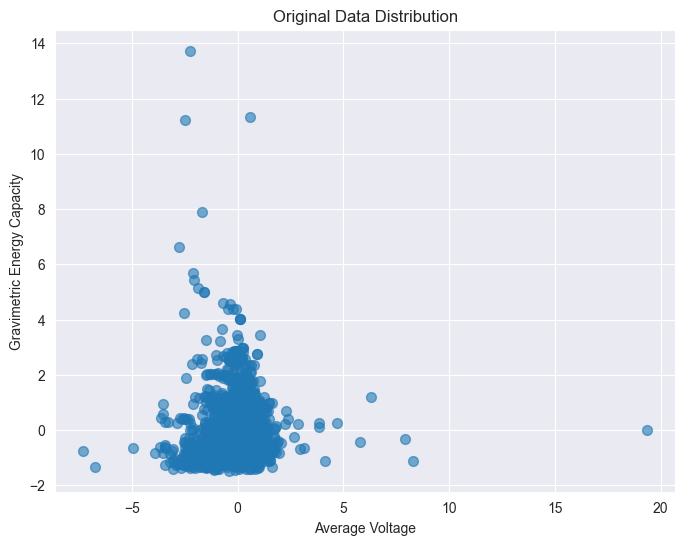

In [12]:
# Step 2:
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], s=50, alpha=0.6)
plt.title("Original Data Distribution")
plt.xlabel("Average Voltage")
plt.ylabel("Gravimetric Energy Capacity")
plt.grid(True)
plt.show()

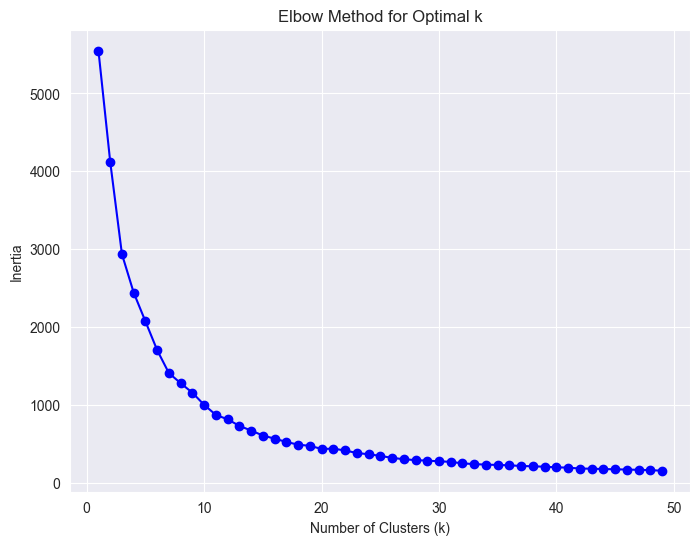

In [13]:
# Step 3: Elbow Method to choose best k
inertias = []
k_values = range(1, 50)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(k_values, inertias, 'bo-')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.grid(True)
plt.show()


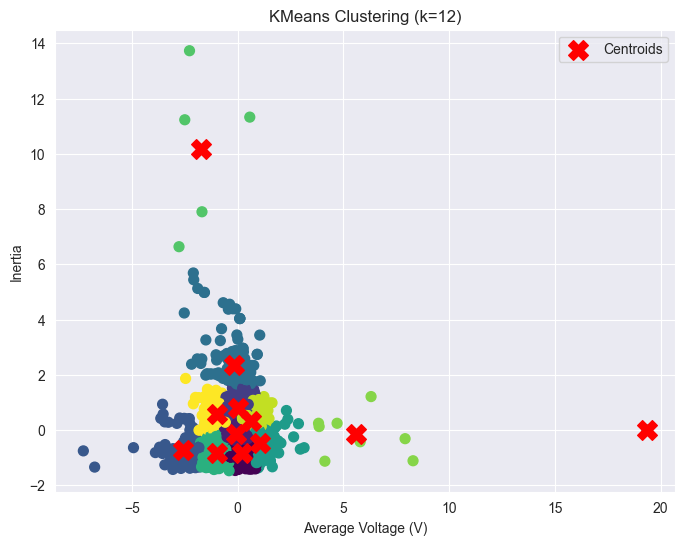

In [14]:
# Step 4: KMeans Clustering
k = 12
kmeans = KMeans(n_clusters=k, random_state=42)
labels_kmeans = kmeans.fit_predict(X)
centroids = kmeans.cluster_centers_

plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=labels_kmeans, cmap='viridis', s=50)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=200, label='Centroids')
plt.xlabel("Average Voltage (V)")
plt.ylabel("Inertia")
plt.title(f"KMeans Clustering (k={k})")
plt.legend()
plt.grid(True)
plt.show()

scores = []
for k in range(2, 20):
    model = KMeans(n_clusters=k) # New instance each time
    labels = model.fit_predict(X)
    score = silhouette_score(X, labels) # Uses current labels
    scores.append(score)

In [15]:
# Step 5: Silhouette Score for KMeans
sil_score_kmeans = silhouette_score(X, labels_kmeans)
print(f"Silhouette Score for KMeans: {sil_score_kmeans:.2f}")

Silhouette Score for KMeans: 0.33


In [9]:
%%sql


Exception: Variable Name is not chosen

In [19]:
for k in range(2, 20):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels_kmeans = kmeans.fit_predict(X)
    # Step 5: Silhouette Score for KMeans
    sil_score_kmeans = silhouette_score(X, labels_kmeans)
    print(f"K value = {k}")
    print(f"Silhouette Score for KMeans: {sil_score_kmeans:.2f}")

K value = 2
Silhouette Score for KMeans: 0.40
K value = 3
Silhouette Score for KMeans: 0.40
K value = 4
Silhouette Score for KMeans: 0.40
K value = 5
Silhouette Score for KMeans: 0.36
K value = 6
Silhouette Score for KMeans: 0.36
K value = 7
Silhouette Score for KMeans: 0.36
K value = 8
Silhouette Score for KMeans: 0.37
K value = 9
Silhouette Score for KMeans: 0.36
K value = 10
Silhouette Score for KMeans: 0.37
K value = 11
Silhouette Score for KMeans: 0.36
K value = 12
Silhouette Score for KMeans: 0.39
K value = 13
Silhouette Score for KMeans: 0.37
K value = 14
Silhouette Score for KMeans: 0.37
K value = 15
Silhouette Score for KMeans: 0.35
K value = 16
Silhouette Score for KMeans: 0.35
K value = 17
Silhouette Score for KMeans: 0.35
K value = 18
Silhouette Score for KMeans: 0.36
K value = 19
Silhouette Score for KMeans: 0.35
